In [143]:
import xarray as xr
import zarr
import glob
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [144]:
zarr_dir = "/home/peter/WRF_MODEL/zarr_out/"
wrf = xr.open_zarr(str(zarr_dir+'d4_1_cpt.zarr'))

Each forecast is 39 hours, this function returns the forecast made x number of succesful forecast runs ago

In [145]:
def get_one_cycle(ds, n):
    steps_in_forecast = 39*4+1
    end = steps_in_forecast*n
    start = steps_in_forecast*(n+1)
    x = wrf.to_array() #convert to DataArray
    if end == 0:
        x =  x[:,-start:]
    else:
        x =  x[:,-start:-end]
    return x.to_dataset(dim = 'variable')

First let's get some observational data to reference against. Here we will use observations from the Cape Town International Airport sourced from the NOAA Integrated Surface Dataset (ISD)- https://www.ncei.noaa.gov/products/land-based-station/integrated-surface-database 

In [147]:
obs_2021 = pd.read_csv('cpt_intl_2021.csv').set_index('DATE')
obs_2022= pd.read_csv('cpt_intl_2022.csv').set_index('DATE')
obs_full = pd.concat([obs_2021, obs_2022])

Some quick data cleaning as the ISD comes in a rather strange format 

In [156]:
wind_df = obs_full['WND'].str.split(',', expand=True).rename(columns = {0:'w_dir', 1:'w_dir_q', 2:'w_type', 3:'w_speed', 4:'w_speed_q'})
wind_df['w_speed'] = wind_df['w_speed'].apply(lambda x: int(x)/10)
wind_df['w_dir'] = wind_df['w_dir'].apply(lambda x: int(x))

temp_df = obs_full['TMP'].str.split(',', expand = True).rename(columns = {0:'temp', 1:'temp_q'})
temp_df['temp'] = temp_df['temp'].apply(lambda x: int(x)/10)
obs = wind_df.join(temp_df)
obs.replace(-999, np.nan, inplace=True)
obs.index = pd.to_datetime(obs.index)

obs = obs.rename(columns = {'temp':'T2', 'w_speed':'ws', 'w_dir':'Dir'})

latitude = obs_full.LATITUDE[-1]
longitude = obs_full.LONGITUDE[-1]

forecast = get_one_cycle(wrf, 2)

forecast = forecast.sel(lat = latitude, method = 'nearest').sel(lon = longitude, method = 'nearest')
forecast = forecast.resample(time='h').mean(dim= 'time')
forecast['ws'] = forecast['ws']*0.514444444
forecast['T2'] = forecast['T2']-273.15

obs = obs[obs.index.isin(forecast.time.values)]
obs = obs[~obs.index.duplicated(keep='first')]

df = obs.join(forecast.to_dataframe()[['ws','Dir','T2']].add_suffix('_forecast'))

In [164]:
df['Forecast_Hour'] = range(len(df))
df = df.set_index('Forecast_Hour')

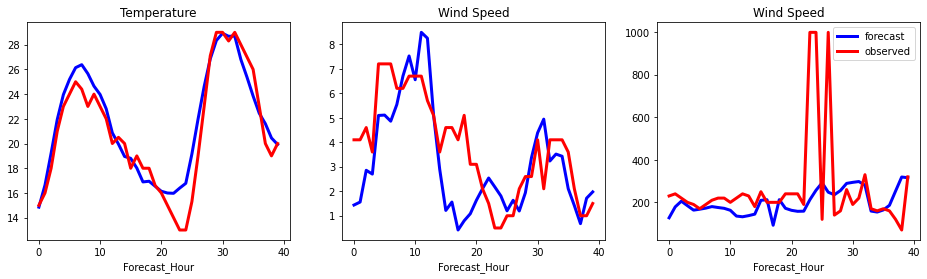

In [165]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(16,4))
axs=axs.flatten()

df.T2_forecast.plot(color = 'Blue', ax = axs[0], lw = 3)
df.T2.plot(color = 'Red' , ax = axs[0], lw = 3)
axs[0].set_title('Temperature')

df.ws_forecast.plot(color = 'Blue', ax = axs[1], lw = 3)
df.ws.plot(color = 'Red' , ax = axs[1], lw = 3)
axs[1].set_title('Wind Speed')

df.Dir_forecast.plot(color = 'Blue', ax = axs[2], lw = 3, label = 'forecast')
df.Dir.plot(color = 'Red' , ax = axs[2], lw = 3, label = 'observed')
axs[2].set_title('Wind Speed')
axs[2].legend()

plt.show()

Let's compare this again the GFS forecast on which this model is based

In [168]:
forecast

<xarray.Dataset>
Dimensions:        (time: 40)
Coordinates:
  * time           (time) datetime64[ns] 2022-03-26T05:00:00 ... 2022-03-27T2...
    lat            float32 -33.97
    lon            float32 18.61
Data variables:
    Dir            (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    T2             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    cloudfrac_low  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pr             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    rh2            (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    slp            (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    u_wind         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    v_wind         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ws             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>